
# **Detecting Fraudulent Transactions**

This case study was inspired by the growing need for enhanced security in
financial transactions. An effective solution is developed using a machine learning model that identifies suspicious patterns by analysing historical data, helping to prevent fraud.


Important to note that in this study we will not perform any exploratory data analysis. The aim is to develop a model that accurately predicts fraudulent transactions and not identify traits and patterns of when and how such transactions are made.


In this particular notebook we will explore the usage of an XGBoost Classifier. The pipeline followed consists of loading the dataset from the provided spreadsheet including the labels, merge them into one dataframe, perform essential feature engineering, encode categorical data, preprocess data for model training, evaluate model performance, and finally identify the optimal threshold that reduces the false positives and negatives.

<br>
Some of the features in the dataset are as follows:

| Feature                  | Description                                      |
|--------------------------|--------------------------------------------------|
| transaction_timestamp     | Time the transaction was made                    |
| transaction_id           | Unique ID for the transaction                    |
| user_account_number      | Account number the transaction was made from     |
| vendor_id                | Unique ID of the vendor                        |
| vendor_category_code    | Category code of vendor                        |
| transaction_value        | Transaction value in GBP                         |
| pos_input_method         | Point Of Sale entry mode                        |
| cash_available           | Available money in account before transaction    |
| vendor_country           | Unique ID of vendor's country                  |
| vendor_zip_code          | Zip code of vendor's postal region             |



In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score, precision_score, recall_score, confusion_matrix, precision_recall_curve, auc, ConfusionMatrixDisplay
from imblearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedRandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from category_encoders import TargetEncoder
from xgboost import XGBClassifier
pd.set_option('future.no_silent_downcasting', True)

In [2]:
class FraudDetectionPipeline:
    def __init__(self, transactions_path, labels_path):
        """
        Initialize the FraudDetectionPipeline with file paths.

        Args:
        transactions_path (str): Path to the transactions CSV file.
        labels_path (str): Path to the labels CSV file.
        """
        self.transactions_path = transactions_path
        self.labels_path = labels_path


    def load_data(self):
        """
        Load transaction and label data from CSV files.

        Returns:
        DataFrame, DataFrame: DataFrames containing the transactions and labels data.
        """
        transactions_df = pd.read_csv(self.transactions_path)
        labels_df = pd.read_csv(self.labels_path)
        return transactions_df, labels_df


    def merge_data(self, transactions_df, labels_df):
        """
        Merge transaction and label data on 'eventId'.

        Args:
        transactions_df (DataFrame): DataFrame containing transactions data.
        labels_df (DataFrame): DataFrame containing labels data.

        Returns:
        DataFrame: Merged DataFrame with an additional 'isFraud' column.
        """
        merged_df = pd.merge(transactions_df, labels_df, on='transaction_id', how='left')
        merged_df['isFraud'] = merged_df['detected_timestamp'].notna().astype(int)
        return merged_df


    def feature_engineering(self, merged_df):
        """
        Perform feature engineering on the merged DataFrame.

        Args:
        merged_df (DataFrame): Merged DataFrame with transactions and labels data.

        Returns:
        DataFrame: DataFrame with engineered features.
        """
        merged_df['transaction_timestamp'] = pd.to_datetime(merged_df['transaction_timestamp'])
        merged_df['detected_timestamp'] = pd.to_datetime(merged_df['detected_timestamp'])

        merged_df['transaction_hour'] = merged_df['transaction_timestamp'].dt.hour
        merged_df['transaction_day_of_week'] = merged_df['transaction_timestamp'].dt.dayofweek

        merged_df['transaction_hour_sin'] = np.sin(2 * np.pi * merged_df['transaction_hour'] / 24)
        merged_df['transaction_hour_cos'] = np.cos(2 * np.pi * merged_df['transaction_hour'] / 24)
        merged_df['transaction_day_of_week_sin'] = np.sin(2 * np.pi * merged_df['transaction_day_of_week'] / 7)
        merged_df['transaction_day_of_week_cos'] = np.cos(2 * np.pi * merged_df['transaction_day_of_week'] / 7)

        merged_df.sort_values(by='transaction_timestamp', inplace=True)
        merged_df['time_since_last_txn'] = merged_df['transaction_timestamp'].diff().dt.total_seconds().fillna(0)

        merged_df['rolling_avg_txn_7d'] = merged_df.groupby('user_account_number')['transaction_value'].transform(lambda x: x.rolling(7).mean())

        self.target_mean_cols = ['vendor_id', 'vendor_zip_code', 'vendor_category_code']
        self.categorical_features = ['pos_input_method', 'vendor_country']

        for col in self.target_mean_cols + self.categorical_features:
            merged_df[col] = merged_df[col].astype(object)

        merged_df = merged_df.drop(columns=['transaction_timestamp', 'detected_timestamp', 'transaction_id', 'user_account_number'])

        return merged_df


    def target_mean_encoding(self, train_val_df, test_df, target):
        """
        Apply target mean encoding to specified columns.

        Args:
        train_val_df (DataFrame): Training and validation DataFrame.
        test_df (DataFrame): Test DataFrame.
        target (str): Target column name.

        Returns:
        DataFrame, DataFrame: DataFrames with target mean encoded columns.
        """
        encoder = TargetEncoder()
        for col in self.target_mean_cols:
            train_val_df[col] = encoder.fit_transform(train_val_df[col], train_val_df[target])
            test_df[col] = encoder.transform(test_df[col])

            # Fill any NaNs in test_df with the mean from train_val_df
            test_df[col] = test_df[col].fillna(train_val_df[col].mean())

        return train_val_df, test_df


    def one_hot_encoding(self, train_val_df, test_df):
        """
        Apply one-hot encoding to categorical features.

        Args:
        train_val_df (DataFrame): Training and validation DataFrame.
        test_df (DataFrame): Test DataFrame.

        Returns:
        DataFrame, DataFrame: DataFrames with one-hot encoded categorical features
        """
        one_hot_encoder = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore') #error

        # Fit and transform on train_val_df
        train_val_encoded = one_hot_encoder.fit_transform(train_val_df[self.categorical_features])

        # Transform test_df
        test_encoded = one_hot_encoder.transform(test_df[self.categorical_features])

        # Create DataFrames with the encoded features
        feature_names = one_hot_encoder.get_feature_names_out(self.categorical_features)
        train_val_encoded_df = pd.DataFrame(train_val_encoded, columns=feature_names, index=train_val_df.index)
        test_encoded_df = pd.DataFrame(test_encoded, columns=feature_names, index=test_df.index)

        # Ensure consistent columns by aligning test to train columns
        test_encoded_df = test_encoded_df.reindex(columns=train_val_encoded_df.columns, fill_value=0)

        # Drop original categorical columns and concatenate encoded features
        train_val_df = train_val_df.drop(columns=self.categorical_features)
        train_val_df = pd.concat([train_val_df, train_val_encoded_df], axis=1)

        test_df = test_df.drop(columns=self.categorical_features)
        test_df = pd.concat([test_df, test_encoded_df], axis=1)

        return train_val_df, test_df


    def preprocess_and_split_data(self, merged_df, target='isFraud', test_size=0.1):
        """
        Preprocess and split data into training, validation, and test sets.

        Args:
        merged_df (DataFrame): Merged DataFrame with engineered features.
        target (str): Target column name.
        test_size (float): Proportion of the dataset to include in the test split.

        Returns:
        DataFrame, DataFrame, DataFrame, Series, Series, Series: Split data (X_train, X_val, X_test, y_train, y_val, y_test).
        """
        # Split into train_val and test sets
        train_val_df, test_df = train_test_split(merged_df,
                                                 test_size=test_size,
                                                 random_state=7,
                                                 stratify=merged_df[target])

        # Check for NaNs in target before encoding
        if merged_df[target].isnull().any():
          print(f"Warning: The target column '{target}' contains NaN values.")

        # Apply target mean encoding and check for NaNs after target encoding
        train_val_df, test_df = self.target_mean_encoding(train_val_df, test_df, target)
        if train_val_df[target].isnull().any().any() or test_df[target].isnull().any().any():
          print("Warning: NaNs found after target mean encoding.")

        # Apply one-hot encoding and check for NaNs again
        train_val_df, test_df = self.one_hot_encoding(train_val_df, test_df)
        if train_val_df[target].isnull().any().any() or test_df[target].isnull().any().any():
          print("Warning: NaNs found after one-hot encoding.")

        # Preparing features and target of combined train and validation set
        X_train_val = train_val_df.drop(columns=[target])
        y_train_val = train_val_df[target]

        # Split train_val into train and validation sets
        X_train, X_val, y_train, y_val = train_test_split(
            X_train_val,
            y_train_val,
            test_size=0.25,
            random_state=7,
            stratify=y_train_val
        )

        X_test = test_df.drop(columns=[target])
        y_test = test_df[target]

        net_size = merged_df.shape[0]
        print('\033[1mSubset Sizes\033[0m')
        print(f'Train set size: {X_train.shape[0]} ({(X_train.shape[0]*100/net_size):.2f} %)')
        print(f'Validation set size: {X_val.shape[0]} ({(X_val.shape[0]*100/net_size):.2f} %)')
        print(f'Test set size: {X_test.shape[0]} ({(X_test.shape[0]*100/net_size):.2f} %)')

        return X_train, X_val, X_test, y_train, y_val, y_test

    def build_and_train_model(self, X_train, y_train):
        """
        Build and train a machine learning model with hyperparameter optimization.

        Args:
        X_train (DataFrame): Training feature data.
        y_train (Series): Training target data.

        Returns:
        Pipeline: Trained model pipeline.
        """
        smote = SMOTE(random_state=7)
        model = XGBClassifier(random_state=7)  # Base model without fixed n_estimators

        # Define the pipeline with preprocessing and SMOTE
        pipeline = make_pipeline(SimpleImputer(strategy='median'), smote, model)

        # Hyperparameter grid
        param_distributions = {
            'xgbclassifier__n_estimators': [100, 200, 300],
            'xgbclassifier__max_depth': [3, 5, 7],
            'xgbclassifier__learning_rate': [0.01, 0.05, 0.1, 0.2],
            'xgbclassifier__subsample': [0.7, 1.0],
            'xgbclassifier__colsample_bytree': [0.7, 1.0],
            'xgbclassifier__scale_pos_weight': [1, 10, 25]  # Useful for imbalanced data
        }

        # Wrap the pipeline in RandomizedSearchCV
        randomized_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_distributions,
            n_iter=30,  # Number of random combinations to try
            scoring='roc_auc',  # Ideal for imbalanced classes
            cv=3,
            random_state=7,
            n_jobs=-1
        )

        # Fit RandomizedSearchCV, which will optimize the pipeline
        randomized_search.fit(X_train, y_train)

        # Print best parameters
        print("Best parameters found:", randomized_search.best_params_)

        # Return the best pipeline
        return randomized_search.best_estimator_

    # def build_and_train_model(self, X_train, y_train):
    #     """
    #     Build and train a machine learning model.

    #     Args:
    #     X_train (DataFrame): Training feature data.
    #     y_train (Series): Training target data.

    #     Returns:
    #     Pipeline: Trained model pipeline.
    #     """
    #     smote = SMOTE(random_state=7)
    #     model = XGBClassifier(n_estimators=100, random_state=7)

    #     pipeline = make_pipeline(SimpleImputer(strategy='median'), smote, model)
    #     pipeline.fit(X_train, y_train)

    #     return pipeline


    def get_feature_importances(self, pipeline, X_train, classifier='xgbclassifier'):
        """
        Get and plot feature importances from the trained model.

        Args:
        pipeline (Pipeline): Trained model pipeline.
        X_train (DataFrame): Training feature data.
        classifier (str): Name of the classifier step in the pipeline.
        """
        feature_importances = pipeline.named_steps[classifier].feature_importances_
        feature_names = X_train.columns

        importance_df = pd.DataFrame({
            'Feature': feature_names,
            'Importance': feature_importances
        }).sort_values(by='Importance', ascending=False)

        plt.figure(figsize=(10, 6))
        sns.barplot(x='Importance', y='Feature', data=importance_df.head(20))
        plt.title('Top 20 Feature Importances')
        plt.show()


    def evaluate_model_on_validation(self, pipeline, X_val, y_val):
        """
        Evaluate the model on the validation set.

        Args:
        pipeline (Pipeline): Trained model pipeline.
        X_val (DataFrame): Validation feature data.
        y_val (Series): Validation target data.

        Returns:
        ndarray: Predicted probabilities for the validation set.
        """
        y_val_pred = pipeline.predict(X_val)
        y_val_pred_proba = pipeline.predict_proba(X_val)[:, 1]

        print("\n> Validation Set Performance:")
        print(f'Precision: {(precision_score(y_val, y_val_pred)):.2f}')
        print(f'Recall: {(recall_score(y_val, y_val_pred)):.2f}')
        print(f'ROC AUC: {(roc_auc_score(y_val, y_val_pred)):.2f}')

        precision, recall, _ = precision_recall_curve(y_val, y_val_pred_proba)
        pr_auc = auc(recall, precision)
        no_skill = len(y_val[y_val==1]) / len(y_val)
        plt.figure(figsize=(8, 6))
        plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
        plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.2f})')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision-Recall Curve (Validation set)')
        plt.legend(loc="best")
        plt.show()

        return y_val_pred_proba


    def find_optimal_threshold(self, y_val, y_val_pred_proba, errors_upper_thres=500):
        """
        Find the optimal decision threshold based on validation set performance.

        Args:
        y_val (Series): Validation target data.
        y_val_pred_proba (ndarray): Predicted probabilities for the validation set.
        errors_upper_thres (int): Upper threshold for combined errors (false positives + false negatives).

        Returns:
        float: Optimal decision threshold.
        """
        print('\n\033[1mFinding optimal decision threshold...\033[0m')

        _, _, thresholds = precision_recall_curve(y_val, y_val_pred_proba)
        optimal_threshold = 0.5
        min_combined_errors = float('inf')

        for threshold in thresholds:
            cur_y_pred = (y_val_pred_proba >= threshold).astype(int)
            tn, fp, fn, tp = confusion_matrix(y_val, cur_y_pred).ravel()
            combined_errors = fp + fn

            if combined_errors <= errors_upper_thres and combined_errors < min_combined_errors:
                min_combined_errors = combined_errors
                optimal_threshold = threshold

        print(f'Optimal threshold: {optimal_threshold:.3f} \n')

        y_pred_optimal = (y_val_pred_proba >= optimal_threshold).astype(int)

        print("\n\033[1m> Validation Set Performance (with optimal decision threshold):\033[0m")
        print(f'Precision: {(precision_score(y_val, y_pred_optimal)):.2f}')
        print(f'Recall: {(recall_score(y_val, y_pred_optimal)):.2f}')
        print(f'ROC AUC: {(roc_auc_score(y_val, y_pred_optimal)):.2f}')

        tn, fp, fn, tp = confusion_matrix(y_val, y_pred_optimal).ravel()
        print(f"False Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"Total False Positives + False Negatives: {fp + fn}")
        print(confusion_matrix(y_val, y_pred_optimal))

        return optimal_threshold


    def evaluate_model_on_test(self, pipeline, X_test, y_test, optimal_threshold):
        """
        Evaluate the model on the test set using the optimal decision threshold.

        Args:
        pipeline (Pipeline): Trained model pipeline.
        X_test (DataFrame): Test feature data.
        y_test (Series): Test target data.
        optimal_threshold (float): Optimal decision threshold.
        """
        y_pred_proba = pipeline.predict_proba(X_test)[:, 1]
        y_pred = (y_pred_proba >= optimal_threshold).astype(int)

        print("\n\033[1m> Holdout Test Set Performance:\033[0m")
        print(f"Precision: {(precision_score(y_test, y_pred)):.2f}")
        print(f'Recall: {(recall_score(y_test, y_pred)):.2f}')
        print(f'ROC AUC: {(roc_auc_score(y_test, y_pred)):.2f}')

        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
        y_pred_optimal = (y_pred_proba >= optimal_threshold).astype(int)

        Confusion_matrix = confusion_matrix(y_test, y_pred_optimal)
        tn, fp, fn, tp = Confusion_matrix.ravel()
        print(f"\nFalse Positives: {fp}")
        print(f"False Negatives: {fn}")
        print(f"Total False Positives + False Negatives: {fp + fn}")
        print(f"False Discovery Rate (FDR): {(fp/(tp + fp)):.1f} %")

        disp = ConfusionMatrixDisplay(Confusion_matrix)
        disp.plot(cmap='Blues')
        plt.title('Confusion Matrix of Test Set')
        plt.show()

        pr_auc = auc(recall, precision)
        plt.figure(figsize=(8, 6))
        plt.plot(recall, precision, label=f'Precision-Recall curve (area = {pr_auc:.1f})')
        plt.legend(loc="best")
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title('Precision Recall Curve (Test Set)')
        plt.show()

In [3]:
# Instantiate the pipeline with file paths
transactions_path = 'transactions.csv'
labels_path = 'labels.csv'
fraud_pipeline = FraudDetectionPipeline(transactions_path, labels_path)

# Load and merge data
transactions_df, labels_df = fraud_pipeline.load_data()
merged_df = fraud_pipeline.merge_data(transactions_df, labels_df)

## Data Transformation and Feature Engineering
The *feature_engineering()* method performs both data transformations, feature engineering but also feature extraction. Finally, it separates the categorical features that will undergo either a target-mean or one-hot encoding.

Several conversions of data types on the time-related columns and to initially transform them into datetime and then extract further information as new features, such as the hour, the day of the week, etc., of a transaction happening.
```
merged_df['transaction_timestamp'] = pd.to_datetime(merged_df['transaction_timestamp'])

merged_df['transaction_hour'] = merged_df['transaction_timestamp'].dt.hour
```
In addition, new cyclic features are created using the sin and cosine of the above new ones, as well as the time gap between two consecutive transactions or even the rolling average per week per account number.


```
merged_df['transaction_hour_sin'] = np.sin(2 * np.pi * merged_df['transaction_hour'] / 24)

merged_df['rolling_avg_txn_7d'] = merged_df.groupby('user_account_number')['transaction_value'].transform(lambda x: x.rolling(7).mean())
```


### Encoding categorical variables
Furthermore, the columns to be encoded are separated depending on the encoding method; i.e. target mean encoding, one-hot encoding.
```
self.target_mean_cols = ['vendor_id', 'vendor_zip_code', 'merchant_category_code']
self.categorical_features = ['pos_input_method', 'vendor_country']
```
Target-mean encoding is typically used for high cardinality categorical variables with many unique categories, and have also strong relationship with target. This makes sure that increased dimensionality and sparsity are avoided. For example, *vendor_id* feature is of high cardinality. Also, *merchant_category_code*, eventhough is of numerical variables, it is a categorical feature of high cardinality too.
```
cardinality = merged_df['vendor_id'].nunique()
print(f"Cardinality of the column: {cardinality}")
Cardinality of the column: 33327
```
On the other hand, features like *vendor_country* and *pos_input_method* are of low cardinality (i.e. less than 100), hence the one-hot encoding.



### Drop unwanted features
Finally, some feature columns are dropped in order to avoid data leakage that would lead to overfitting. For example, training the model using the independent feature accountNumber against which transactions are fraudulent, would automatically bias our model and not be able to generalise to unknown and new account numbers.

```
merged_df = merged_df.drop(columns=['transaction_timestamp', 'reported_timestamp', 'transaction_id', 'user_account_number'])
```

In [4]:
# Perform feature engineering on merged data
merged_df = fraud_pipeline.feature_engineering(merged_df)

## Data Splitting
In the following cell, the *preprocess_and_split_data()* method is called to split the data into train-validation and test, and then encode them accordingly.

The preprocessing function performs the encoding of the train-validation separate to the test set. This makes sure that no data leakage is taking place during encoding between the train-val to test. We need the test set to be unforeseen by the model so that the evaluation of its performance is just.

Once the encoding is performed, then the train-val dataset are split further to train and validation sets to be used in model training.

NB. Shuffling and stratification is always used to create randomness while maintaining the ratio of fraud/legit in all datasets. Again, this ensures that splits are repsresentative of the original data and any possible bias is reduced.

In [5]:
# Split data into training, validation, and test sets
X_train, X_val, X_test, y_train, y_val, y_test = fraud_pipeline.preprocess_and_split_data(merged_df)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


Subset Sizes
Train set size: 80068 (67.50 %)
Validation set size: 26690 (22.50 %)
Test set size: 11863 (10.00 %)


## Model Development
A pipeline is created incorporating data imputation and resampling in the model. Data imputation aims to fill in missing values in the training data using the median, avoiding any bias from the outliers. Furthermore, fraudulent transactions are always a minority against the total number of transactions. This means that our dataset is severely imbalanced and our minority class which is the important one will not be sufficiently and accurately predicted.

Therefore, SMOTE (Synthetic Minority Over-sampling Technique), which is a method for addressing class imbalance, is used to creates synthetic samples for the minority class by generating new examples between existing ones.

The machine learning algorithm used here is an XGBoost Classifier. XGBoost can effectively work with high-cardinality categorical features, while through regularization it prevents possible overfitting. Fraudulent activity often has complex, nonlinear relationships across features like time, merchant ID, and transaction entry mode. XGBoost, as a boosted tree algorithm, captures these non-linear patterns well.

Furthermore, a RandomizedSearchCV is used to try a set of combinations of model hyperparameters and identify the best. It was found that it achieved slightly lower performance than the default model's hyperparameters (i.e. 22% more false predictions).




| Hyperparameter        | Best Parameter Value | Default Value | Description                                      |
|-----------------------|----------------------|---------------|--------------------------------------------------|
| n_estimators          | 200                  | 100           | Number of trees (boosting rounds).               |                        |
| max_depth             | 5                    | 6             | Maximum depth of a tree.                         |
| learning_rate         | 0.1                  | 0.3           | Step size shrinkage to prevent overfitting.     |
| subsample             | 1.0                  | 1.0           | Fraction of the training samples used for each tree. |
| colsample_bytree      | 0.7                  | 1.0           | Fraction of features used at each tree.         |
| scale_pos_weight      | 1                    | 1             | Balancing of positive and negative weights.      |

In [6]:
# Build and train the model
pipeline = fraud_pipeline.build_and_train_model(X_train, y_train)

Best parameters found: {'xgbclassifier__subsample': 0.7, 'xgbclassifier__scale_pos_weight': 1, 'xgbclassifier__n_estimators': 200, 'xgbclassifier__max_depth': 5, 'xgbclassifier__learning_rate': 0.1, 'xgbclassifier__colsample_bytree': 0.7}


## Evaluating model before optimal decision threshold
The validation set is used to evaluate the model. It is found that the model's performance is not bad, taking into account the fact that our dataset was initially imbalanced and new synthetic data is produced. The precision and recall values of 0.74 are acceptable, since a team of fraud data analyst will have the capacity to work through 500 transactions per month.


> Validation Set Performance:
Precision: 1.00
Recall: 0.99
ROC AUC: 1.00


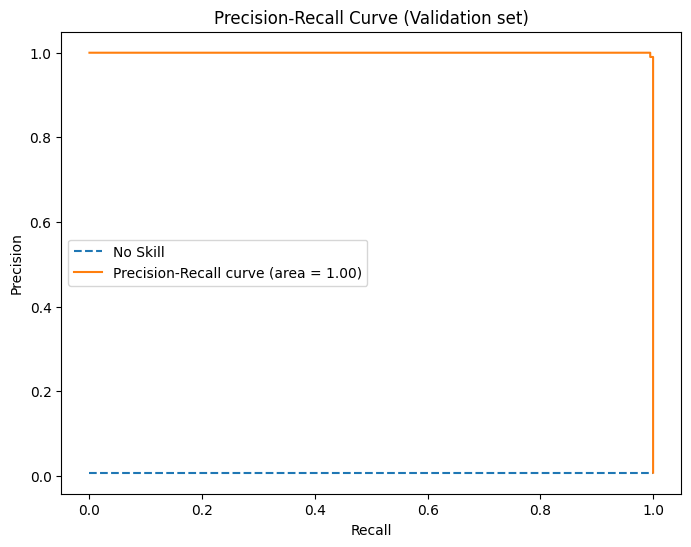

In [7]:
# Evaluate model on validation set
y_val_pred_proba = fraud_pipeline.evaluate_model_on_validation(pipeline, X_val, y_val)

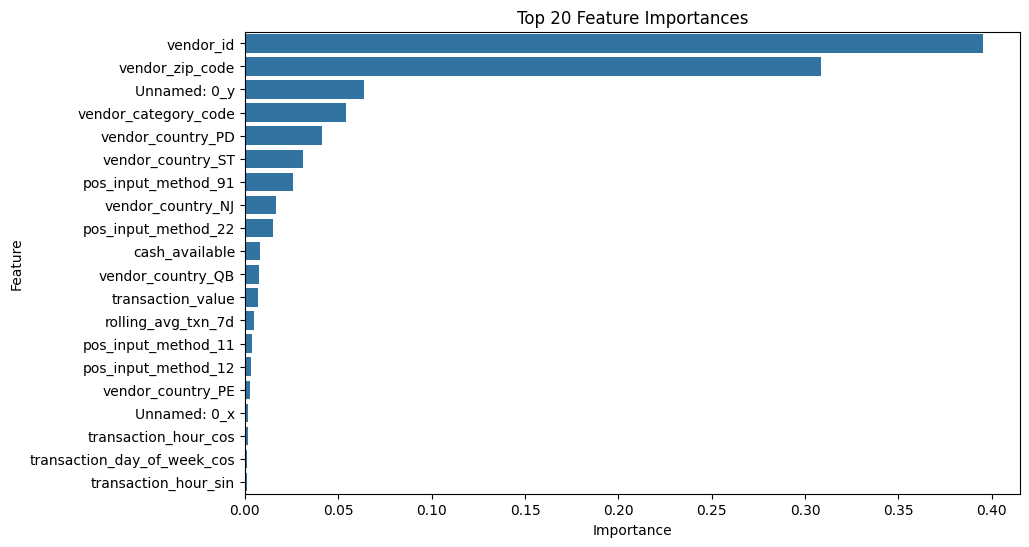

In [8]:
# Plot feature importances
fraud_pipeline.get_feature_importances(pipeline, X_train, classifier='xgbclassifier')

## Optimal Decision Threshold
The default decision threshold is typically set to 0.5; anything above that is classified as a fraudulent transaction. However, it does not mean it is the optimal decision threshold value as it highly depends on what is the objective of the business problem.

In our case, we want to minimise the total falses so that the analyst team will have less misses to worry about. To achieve this, a *find_optimal_threshold()* method is created to identify the threshold value leading to the least amount of falses.

According to the output of the function, the optimal threshold is found at 0.963. This is beneficial in cases where the cost of a false positive is high (e.g., incorrectly flagging a legitimate transaction as fraud).

In [9]:
# Find optimal decision threshold
optimal_threshold = fraud_pipeline.find_optimal_threshold(y_val, y_val_pred_proba)


Finding optimal decision threshold...
Optimal threshold: 0.963 


> Validation Set Performance (with optimal decision threshold):
Precision: 1.00
Recall: 0.99
ROC AUC: 1.00
False Positives: 0
False Negatives: 1
Total False Positives + False Negatives: 1
[[26493     0]
 [    1   196]]



> Holdout Test Set Performance:
Precision: 1.00
Recall: 0.97
ROC AUC: 0.98

False Positives: 0
False Negatives: 3
Total False Positives + False Negatives: 3
False Discovery Rate (FDR): 0.0 %


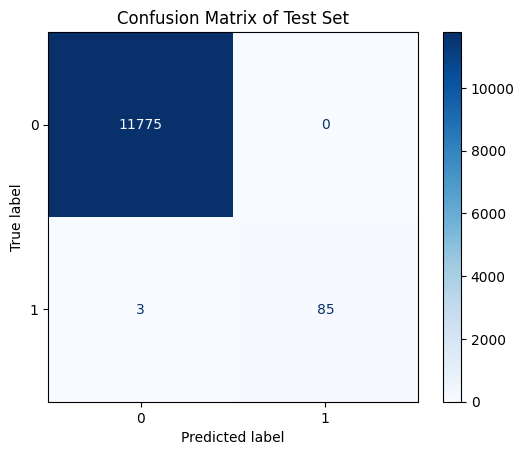

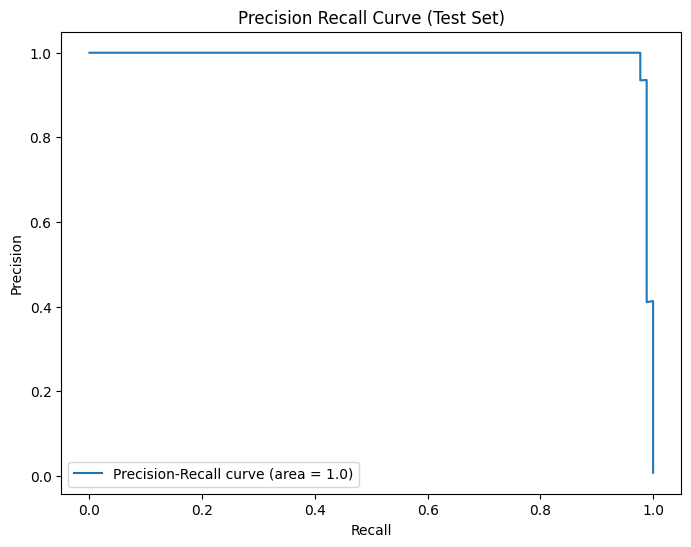

In [10]:
# Evaluate model on test set with optimal threshold
fraud_pipeline.evaluate_model_on_test(pipeline, X_test, y_test, optimal_threshold)